In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# alternate loading system


In [2]:
imageList = tf.data.Dataset.list_files(os.path.join('data', '*.png'), 
                                   shuffle = False)
textList = tf.data.Dataset.list_files(os.path.join('data', '*.txt'),
                                      shuffle = False)


imagecount = len(imageList)
print(imagecount)
textcount = len(textList)
print(textcount)

2524
2524


In [3]:
for f in imageList.take(5):
  print(f.numpy())


b'data\\002b6c17-1901-11ee-a632-001a7dda7115.png'
b'data\\004a045c-1901-11ee-bbb3-001a7dda7115.png'
b'data\\0068d956-1901-11ee-a39c-001a7dda7115.png'
b'data\\0087903e-1901-11ee-9b96-001a7dda7115.png'
b'data\\00c2f316-1901-11ee-aa05-001a7dda7115.png'


In [4]:
def preprocess(filepath):
    # this is the function that will process all the images that are in the image list for basic conversion

    #read image
    img = tf.io.read_file(filepath)
    #load image
    img = tf.io.decode_png(img, channels=3)
    #scaled the image to be 0-1
    img = img / 255

    img = tf.image.central_crop(image=img, central_fraction=0.80)

    #img = tf.image.rgb_to_grayscale(img)


    return img

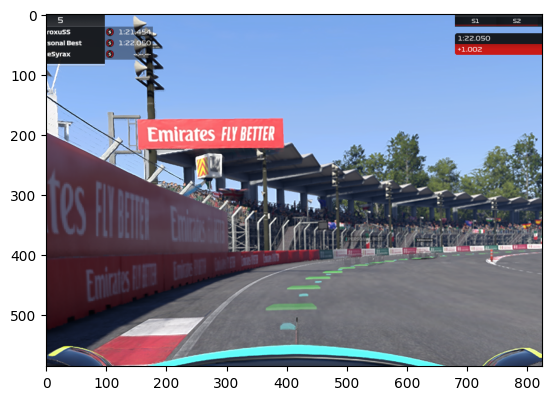

In [5]:
imageList = imageList.map(preprocess)
plt.imshow(imageList.as_numpy_iterator().next(), cmap='gray')


In [6]:
def preprocess_text(filepath):

    key = tf.io.read_file(filepath)

    if key == 'up arrow\r\n':
        return [1,0,0,0]
    if key == 'down arrow\r\n':
        return [0,1,0,0]
    if key == 'left arrow\r\n':
        return [1,0,0,0]
    if key == 'right arrow\r\n':
        return [0,0,0,1]
    if key == 'left arrow,up arrow\r\n':
        return [1,0,1,0]
    if key == 'left arrow,down arrow\r\n':
        return [0,1,1,0]
    if key == 'right arrow,up arrow\r\n':
        return [1,0,0,1]
    if key == 'right arrow,down arrow\r\n':
        return [0,1,0,1]
    else:
        return [0,0,0,0]
    return key 

In [7]:
def wrap_array(x1,x2,x3,x4):
    return tf.expand_dims([x1,x2,x3,x4], axis = 0)

In [8]:
textList = textList.map(lambda x: tf.py_function(preprocess_text, [x], ([tf.int16, tf.int16, tf.int16, tf.int16,])))
textList = textList.map(wrap_array)


In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Input

normalization_layer = tf.keras.layers.Rescaling(1./255)




In [10]:
val_size = int(0.2 * imagecount)

train_image = imageList.skip(val_size)
train_text = textList.skip(val_size)
val_image = imageList.take(val_size)
val_text = textList.take(val_size)

print(len(val_image), len(train_image))

504 2020


In [12]:
train_ds = tf.data.Dataset.zip((train_image, train_text))
val_ds = tf.data.Dataset.zip((val_image, val_text))

#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (586, 826, 3)
Label:  [[1 0 1 0]]


In [36]:
AUTOTUNE = tf.data.AUTOTUNE


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(8)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  ds = ds.map(unwrap)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = val_ds.map(unwrap)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

KeyboardInterrupt: 

c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


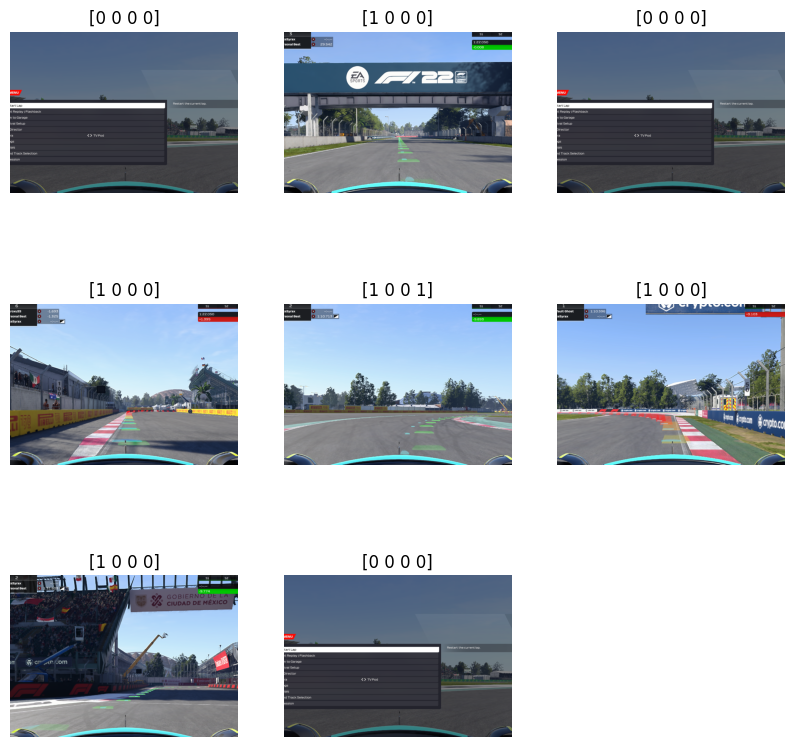

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(8):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(label_batch[i].numpy())
  plt.axis("off")


In [35]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (8, 586, 826, 3)
Label:  (8, 4)


In [16]:
#tf.reshape(train_ds, [586, 826])

model = Sequential()

print(imageList.as_numpy_iterator().next().shape)

model.add(keras.Input(shape=((586, 826, 3))))

model.add(Conv2D(64,  #filters
                  5,  #kernel size
                  strides = (3,3),   #reducing the compression so its not 400 million parameters lkmfaoooo
                activation = 'relu',  #activation type
                input_shape =((586, 826, 3))))    #input shape (batch, shape as seen above)#

model.add(BatchNormalization())

model.add(MaxPooling2D())

model.add(Conv2D(128, 4, 
                 strides = (3,3),
                   activation='relu'))

model.add(BatchNormalization())


model.add(Conv2D(128, 3, 
                 strides = (3,3),
                   activation='relu'))


model.add(BatchNormalization())

model.add(Conv2D(256, 2, 
                 strides = (3,3),
                   activation='relu'))


model.add(BatchNormalization())



model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(4, activation='softmax'))

(586, 826, 3)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 194, 274, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 194, 274, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 137, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 45, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 45, 128)      512       
 hNormalization)                                                 
                                                        

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [29]:
model.fit(train_ds, validation_data=val_ds, epochs=100)


Epoch 1/100


ValueError: in user code:

    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "c:\Users\ayman\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.
